## Initial Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scm.plams import init, packmol, Settings, AMSJob, from_smiles, plot_molecule

## Run Simple MD Simulation of Water

Run a short MD simulation of 16 water molecules in a box.

In [2]:
# this line is not required in AMS2025+
init()

mol = packmol(from_smiles("O"), n_molecules=16, density=1.0)
s = Settings()
s.input.ams.Task = "MolecularDynamics"
s.input.ReaxFF.ForceField = "Water2017.ff"
s.input.ams.MolecularDynamics.CalcPressure = "Yes"
s.input.ams.MolecularDynamics.InitialVelocities.Temperature = 300
s.input.ams.MolecularDynamics.Trajectory.SamplingFreq = 1
s.input.ams.MolecularDynamics.TimeStep = 0.5
s.input.ams.MolecularDynamics.NSteps = 2000
s.runscript.nproc = 1
os.environ["OMP_NUM_THREADS"] = "1"
job = AMSJob(settings=s, molecule=mol, name="md")
job.run()

PLAMS working folder: /path/plams/examples/BasicMDAnalysis/plams_workdir
[03.03|11:50:24] JOB md STARTED
[03.03|11:50:24] JOB md RUNNING
[03.03|11:50:28] JOB md FINISHED
[03.03|11:50:28] JOB md SUCCESSFUL


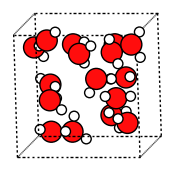

In [3]:
plot_molecule(mol, rotation=("80x,10y,0z"));

Or alternatively, load a previously run MD job:

In [4]:
# job = AMSJob.load_external('/path/to/ams.rkf')
results = job.results

## Velocity Autocorrelation Function

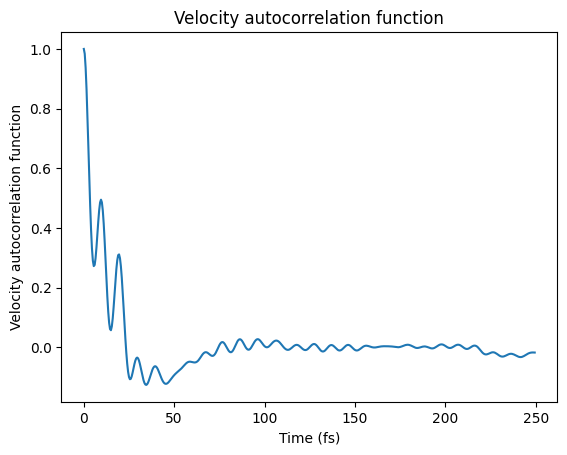

In [5]:
times, vacf = results.get_velocity_acf(start_fs=0, max_dt_fs=250, normalize=False)
normalized_vacf = vacf / vacf[0]
plt.plot(times, normalized_vacf)
plt.xlabel("Time (fs)")
plt.ylabel("Velocity autocorrelation function")
plt.title("Velocity autocorrelation function")
plt.savefig("plams_vacf.png")
A = np.stack((times, normalized_vacf), axis=1)
np.savetxt("plams_vacf.txt", A, header="Time(fs) VACF")

## Diffusion Coefficient

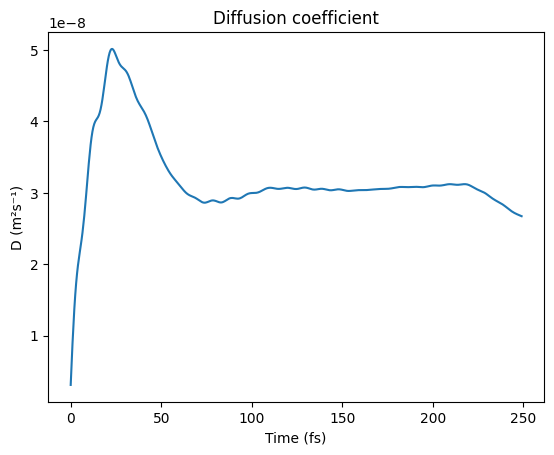

In [6]:
t_D, D = results.get_diffusion_coefficient_from_velocity_acf(times, vacf)
plt.plot(t_D, D)
plt.xlabel("Time (fs)")
plt.ylabel("D (m²s⁻¹)")
plt.title("Diffusion coefficient")
plt.savefig("plams_vacf_D.png")
A = np.stack((t_D, D), axis=1)
np.savetxt("plams_vacf_D.txt", A, header="time(fs) D(m^2*s^-1)")

## Power Spectrum

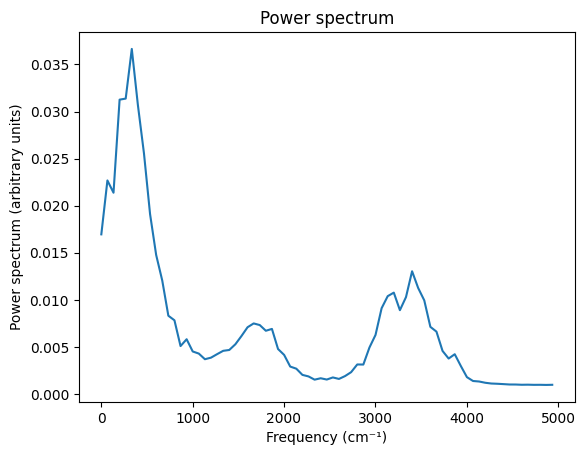

In [7]:
freq, intensities = results.get_power_spectrum(times, vacf, number_of_points=1000)
plt.plot(freq, intensities)
plt.xlabel("Frequency (cm⁻¹)")
plt.ylabel("Power spectrum (arbitrary units)")
plt.title("Power spectrum")
plt.savefig("plams_power_spectrum.png")
A = np.stack((freq, intensities), axis=1)
np.savetxt("plams_power_spectrum.txt", A, header="Frequency(cm^-1) PowerSpectrum")

## Green-Kubo Viscosity 

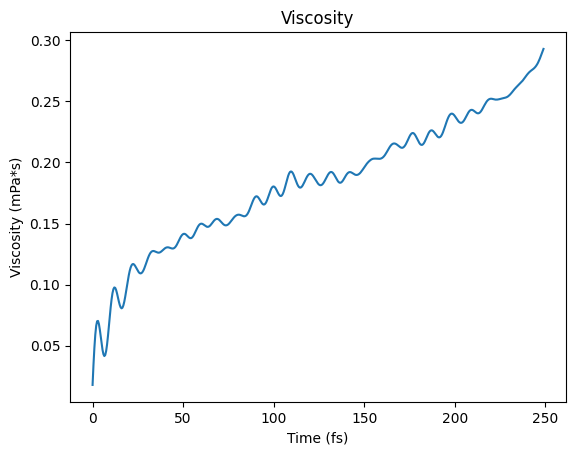

In [8]:
t, viscosity = results.get_green_kubo_viscosity(start_fs=0, max_dt_fs=250)  # do not do this for NPT simulations
plt.plot(t, viscosity)
plt.xlabel("Time (fs)")
plt.ylabel("Viscosity (mPa*s)")
plt.title("Viscosity")
plt.savefig("plams_green_kubo_viscosity.png")
A = np.stack((t, viscosity), axis=1)
np.savetxt("plams_green_kubo_viscosity.txt", A, header="Time(fs) Viscosity(mPa*s)")

## Density Along Axis

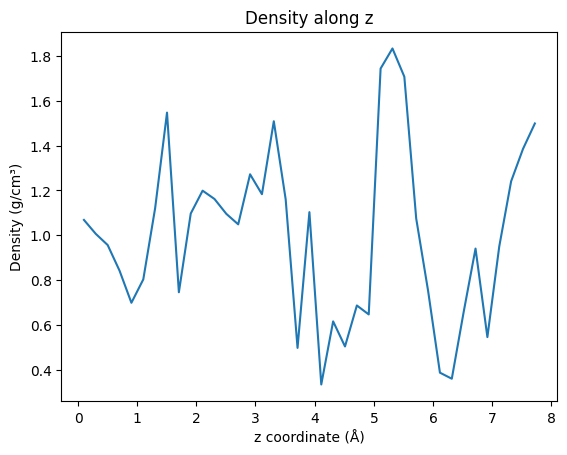

In [9]:
z, density = results.get_density_along_axis(axis="z", density_type="mass", bin_width=0.2, atom_indices=None)
plt.plot(z, density)
plt.xlabel("z coordinate (Å)")
plt.ylabel("Density (g/cm³)")
plt.title("Density along z")
plt.savefig("plams_density_along_z.png")
A = np.stack((z, density), axis=1)
np.savetxt("plams_density_along_z.txt", A, header="z(angstrom) density(g/cm^3)")